# Описание задачи

Задача построить аплифт модель, которая будет выдавать склонность клиента для выполнения целевого действия, после взаимодействия выбранной кампанией.

Вкратце об отличии класического ml от uplift. В классическом ml мы у нас есть факт выполения/наличия какого-то действия по заданным признакам, те если есть такие то признаки то результат должен быть один. В uplift моделировании у нас   есть факт выполения действия при наличии или отсутсвии взаимодействия, проблема в том что нельзя одновременно знать как поведет себя пользователь при наличии и отсутсвии взаимодействия. Те задача сводится к тому чтобы найти такие Y=1 (выполнение действия) только при наличии W=1 (наличии взаимодействия)

В рамках данной задачи, нужно обучить моделить находить такую группу клиентов, которая посетила сайт только после наличии комуникации.

In [1]:
from utils.data.statistics import *
from utils.data.preprocessing import *
from utils.model.uplift import *

In [2]:
# !pip install scikit-uplift

In [3]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost import XGBRFClassifier
from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklift.metrics import uplift_at_k
from sklift.metrics import weighted_average_uplift
from sklift.metrics import uplift_by_percentile
from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_preds
from sklift.viz import plot_uplift_curve
import joblib

In [4]:
pd.set_option('display.max_columns', 100)

In [5]:
df = read_dataframe()

minethatdata_womens_train.csv - файл с обучающей выборкой

***Описание клиента до рассылки (контекст):***
- Index - id пользователя
- Recency - кол-во месяцев с последней покупки
- History_segment - категория (по кол-ву у.е. потраченных за последний год)
- History - кол-во $ потраченных за последний год
- Mens - индикатор, - клиент купил товары для мужчин за последний год
- Womens - индикатор, - клиент купил товары для женщин за последний год
- Zip_code - региональная категория индексов. Urban, Suburban, Rural
- Newbie - индикатор, новый клиент пришел в магазин в первый раз за последние
месяцев
- Channel - описывает способы приобретения клиентом товаров за последний год
- Segment - mens e-mail / women’s e-mail / no e-mail (то к какой категории
отнесен клиент)

***Переменные описывающие клиента в течение недель после получения e-mail:***
- Visit - индикатор, - клиент посетил сайт в последующие недели после рассылки (то для чего нужно построить uplift модель)
- Conversion - индикатор, - клиент купил товары на сайте в последующие недели после рассылки
- Spend - кол-во (у.е.) потраченных на покупки в последующие

In [6]:
df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
index,,,,,,,,,,,,
54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0
30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0,0,0.0
2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,No E-Mail,0,0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21346 entries, 54222 to 24655
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          21346 non-null  int64  
 1   history_segment  21346 non-null  object 
 2   history          21346 non-null  float64
 3   mens             21346 non-null  int64  
 4   womens           21346 non-null  int64  
 5   zip_code         21346 non-null  object 
 6   newbie           21346 non-null  int64  
 7   channel          21346 non-null  object 
 8   segment          21346 non-null  object 
 9   visit            21346 non-null  int64  
 10  conversion       21346 non-null  int64  
 11  spend            21346 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 2.1+ MB


In [8]:
df.describe()

,recency,history,mens,womens,newbie,visit,conversion,spend
count,21346.000000,21346.000000,21346.000000,21346.000000,21346.000000,21346.000000,21346.000000,21346.000000
mean,5.777663,242.426965,0.551110,0.550408,0.501968,0.125035,0.006746,0.858455
std,3.512457,255.637677,0.497393,0.497464,0.500008,0.330766,0.081858,14.028167
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,65.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,159.090000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,9.000000,325.120000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000,499.000000


Построим корреляцию Пирсона, если найдем сильный линейный тренд м/у данными, то можем рассмотреть вариант исключения этих данных

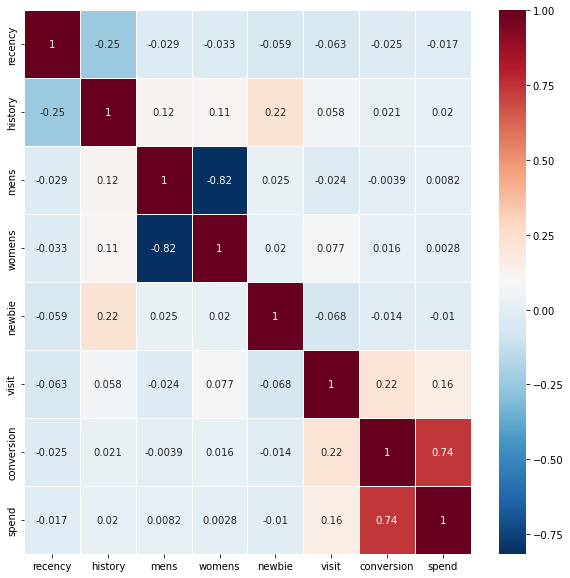

In [9]:
get_dataframe_pearsoncorr(df)

Найдем категориальные столбцы

Womens и mens совпадают линейно на 82 процента, что не удивительно, а conversion и spent на 74 процента. Пока не будем удалять эти данные, но оставим за собой эту возможность, для следующей итерации

In [10]:
get_dataframe_statistics(df)

recency has 12 unique variables
--------------------
history_segment has 7 unique variables
--------------------
history has 15546 unique variables
--------------------
mens has 2 unique variables
--------------------
womens has 2 unique variables
--------------------
zip_code has 3 unique variables
--------------------
newbie has 2 unique variables
--------------------
channel has 3 unique variables
--------------------
segment has 2 unique variables
--------------------
visit has 2 unique variables
--------------------
conversion has 2 unique variables
--------------------
spend has 108 unique variables
--------------------


Выделим для дальнейшего преобразования  history type и spend для стандартизации, history_segment, zip_code и channel для onehot encoding. Для переменных типа 1/0 преобразований делать не будем

Переименеруем segment в treatment_flg, а visit в target

In [11]:
df = prepare_treatment_target_columns(df)

Посмотрим на результат

In [12]:
df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment_flg,target,conversion,spend
index,,,,,,,,,,,,
54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,0,0,0,0.0
30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,1,0,0,0.0
2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,0,0,0,0.0


Посмотрим в каком отношении разбили клиентов для проведения кампании

In [13]:
for i in df['treatment_flg'].unique():
    print(i, df[df['treatment_flg'] == i]['treatment_flg'].count())

0 10637
1 10709


Видно, что отношение 1:1, следовательно можем использовать в том числе и модель трансформации классов, но об этом чуть позже

Посмотрим в каком отношении разбили клиентов для проведения кампании, относительно каналов через которые они совершали покупки

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


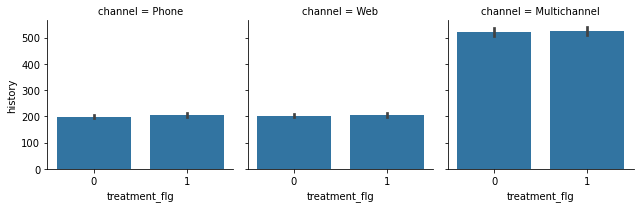

In [14]:
g = sns.FacetGrid(df, col="channel", height=3, aspect=1)
g.map(sns.barplot, "treatment_flg", 'history')

Видно, что данные были взяты случайным образом, поэтому история покупок совпадает по всем каналам

Посмотрим, как изменилось повдеение клиентов после кампании, будет ли наблюдаться увеличение доли покупок у клиентов, с которыми провзаимодействовали

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


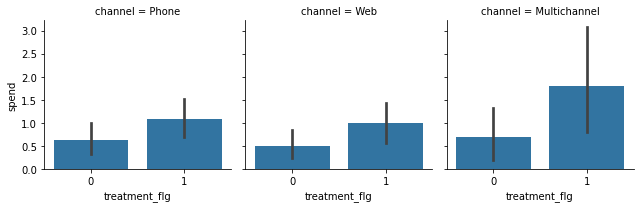

In [15]:
g = sns.FacetGrid(df, col="channel", height=3, aspect=1)
g.map(sns.barplot, "treatment_flg", 'spend')

Видно, что есть положительный эффект от кампании, попробуем выяснить, получилось ли это случайным образом или есть тот самый uplift

**Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам**

То есть за нулевую гипотезу берем предположение, что после проведения кампании, число визитов на сайте не поменялось. Если статитистическая значимость превысит порог в 0.05, то нулевую гипотезу отвергнуть не сможем

In [16]:
sample_without_treatment = df[df['treatment_flg'] == 0]['target'].values
sample_with_treatment = df[df['treatment_flg'] == 1]['target'].values

Найдем разниму между целевыми переменными для treatment и конторольной групп

In [17]:
sample_without_treatment.mean(), sample_without_treatment.std()

(0.10172040989000658, 0.30228028070288615)

In [18]:
sample_with_treatment.mean(), sample_with_treatment.std()

(0.1481931086002428, 0.35529130465526376)

In [19]:
sample_with_treatment.mean() - sample_without_treatment.mean()

0.04647269871023621

Среднее отличается по откликам группы на которую делали кампанию отличается на 4.6 процента от той, где кампании не было

Проверим нулевую гипотезу, посмотрим это случная величина или все же увеличение откликов связано с проведением кампании

In [20]:
statistic, pvalue = st.ttest_ind(sample_without_treatment,
                                 sample_with_treatment,
                                 equal_var=False)

In [21]:
print('statistic = {:.2f}, pvalue = {:.26f}'.format(statistic, pvalue))

statistic = -10.29, pvalue = 0.00000000000000000000000086


In [22]:
print('p-значение =', pvalue, ' < 0.05', 'можно отвергнуть нулевую гипотезу')

p-значение = 8.562583501755613e-25  < 0.05 можно отвергнуть нулевую гипотезу


Так как можем отвергнуть нулевую гипотезу, то будем искать тех клиентов на которых влияет кампания.Тут можно остановиться и сделать промежуточный вывод: так как виден эффек uplift для группы treatment и он не случаен, то если 4.6 это достаточный эффек прироста кликов на выделенный бюджет кампании, то можно и не делать дальнейшие шаги по поиску модели определяющей группы клиентов на которых взаимодействие принисет положительный эффект. Те можно просто сделать рассылку на всех и получить прирост по кликам на 4.6 процента, одним словом - сплошной профит.

Но так как мы тут решили делать uplift а не просто повышать кликабельность, то продолжим анализировать данные, а именно займемся их подготовкой.

Разобьем на треин и тест

In [23]:
train, test = str_shuf_train_test_split(df)
train, test = str_shuf_train_test_split(df)

Сравним как отличаются среднии по таргету в treatment и control группах, в исходном датафрейме, трейне и тесте

In [24]:
df[df['treatment_flg'] == 1]['target'].describe() - df[df['treatment_flg'] == 0]['target'].describe()

count    72.000000
mean      0.046473
std       0.053013
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: target, dtype: float64

In [25]:
train[train['treatment_flg'] == 1]['target'].describe() - train[train['treatment_flg'] == 0]['target'].describe()

count    123.000000
mean       0.048759
std        0.054473
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000000
Name: target, dtype: float64

In [26]:
test[test['treatment_flg'] == 1]['target'].describe() - test[test['treatment_flg'] == 0]['target'].describe()

count   -51.000000
mean      0.044073
std       0.051360
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: target, dtype: float64

Флуктуации в диапазоне меньше 1 процетнта, можно говорить об успешном разбиении

Трансформируем данные

In [27]:
train_transformed, test_transformed = full_preprocessing_pipline(train, test, df)

In [28]:
train_transformed.head(3)

,history,spend,history_segment_2,history_segment_3,history_segment_4,history_segment_5,history_segment_6,history_segment_7,zip_code_Rural,zip_code_Urban,channel_Multichannel,channel_Web,target,mens,conversion,newbie,womens,treatment_flg,recency
index,,,,,,,,,,,,,,,,,,,
56780,-0.826870,-0.063007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1,0,9
62165,-0.193770,-0.063007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,1,0,1,5
2958,7.423522,-0.063007,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,1,0,1,0,1,1


Разобьем данные на X, y, treat для использования библиотеки sklift

In [29]:
X_train, y_train, treat_train = prepare_data_for_sklift(train_transformed)

In [30]:
X_test, y_test, treat_test = prepare_data_for_sklift(test_transformed)

In [31]:
X_test.head(3)

,history,spend,history_segment_2,history_segment_3,history_segment_4,history_segment_5,history_segment_6,history_segment_7,zip_code_Rural,zip_code_Urban,channel_Multichannel,channel_Web,mens,conversion,newbie,womens,recency
index,,,,,,,,,,,,,,,,,
58483,-0.673299,-0.063007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,1,1,5
54369,-0.394863,-0.063007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0,0,0,1
19512,-0.617389,-0.063007,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0,1,0,1


# ВЫБОР МОДЕЛИ

Далее опишем какие модели использовались для решения задачи uplift. Интернет особо не блещет изьяснениями на данную тему, а крупицы доступной информации на русском повторяются из источника в источник, в свою очередь анлоглоязычной информации чуть больше, но она была сжата и переведена на русский язык. А как было сказано выше, все что сжато и переведено - повторяет друг друга. Поэтому продолжая традицию копи паста, привожу алгоритмы моделей, которые были использованы в данном задании с их небольшим описанием, естественно скопированного из других источников(например https://nbviewer.jupyter.org/github/maks-sh/scikit-uplift/blob/master/notebooks/RetailHero.ipynb).

Далее все что <font color='blue'>синим</font> не мои мысли.

## 1. Подходы с одной моделью

### 1.1 Одна модель с признаком коммуникации
<font color='blue'>Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.</font> 


<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/SoloModel_RU.png" alt="Solo model with treatment as a feature"/>
</p>

### 1.2 Трансформация классов

<font color='blue'>Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:</font> 

$$
Z_i = Y_i \cdot W_i + (1 - Y_i) \cdot (1 - W_i),
$$
<font color='blue'>где 

* $Z_i$ - новая целевая переменная $i$-ого клиента; 
* $Y_i$ - целевая перемнная $i$-ого клиента;
* $W_i$ - флаг коммуникации $i$-ого клиента;  
</font> 


<font color='blue'>Другими словами, новый класс равен 1, если мы знаем, что на конкретном наблюдении, результат при взаимодействии был бы таким же хорошим, как и в контрольной группе, если бы мы могли знать результат в обеих группах:</font> 

$$
Z_i = \begin{cases}
    1, & \mbox{if } W_i = 1 \mbox{ and } Y_i = 1 \\
    1, & \mbox{if } W_i = 0 \mbox{ and } Y_i = 0 \\
    0, & \mbox{otherwise}
   \end{cases}
$$

<font color='blue'>Распишем подробнее, чему равна вероятность новой целевой переменной:</font> 

$$ 
P(Z=1|X = x) = \\
= P(Z=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Z=1|X = x, W = 0) \cdot P(W = 0|X = x) = \\
= P(Y=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Y=0|X = x, W = 0) \cdot P(W = 0|X = x).
$$

<font color='blue'>Выше мы обсуждали, что обучающая выборка для моделирования uplift собирается на основе рандомизированного разбиения части клиенской базы на тестовую и контрольную группы. Поэтому коммуникация $ W $ не может зависить от признаков клиента $ X_1, ..., X_m $. Принимая это, мы имеем: $ P(W | X_1, ..., X_m, ) = P(W) $ и </font> 

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot P(W = 1) + \\
+ P^C(Y=0|X = x) \cdot P(W = 0)
$$

<font color='blue'>Также допустим, что $P(W = 1) = P(W = 0) = \frac{1}{2}$, т.е. во время эксперимента контрольные и тестовые группы были разделены в равных пропорциях. Тогда получим следующее:</font> 

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot \frac{1}{2} + P^C(Y=0|X = x) \cdot \frac{1}{2} \Rightarrow \\
2 \cdot P(Z=1|X = x) = \\
= P^T(Y=1|X = x) + P^C(Y=0|X = x) = \\
= P^T(Y=1|X = x) + 1 - P^C(Y=1|X = x) \Rightarrow \\
\Rightarrow P^T(Y=1|X = x) - P^C(Y=1|X = x) = \\
 = uplift = 2 \cdot P(Z=1|X = x) - 1
$$

<font color='blue'>Таким образом, увеличив вдвое прогноз нового таргета и вычтя из него единицу мы получим значение самого uplift'a, т.е.</font> 

$$
uplift = 2 \cdot P(Z=1) - 1
$$

<font color='blue'>Исходя из допущения описанного выше: $P(W = 1) = P(W = 0) = \frac{1}{2}$, данный подход следует использовать только в случаях, когда количество клиентов, с которыми мы прокоммуницировлаи, равно количеству клиентов, с которыми коммуникации не было.</font> 

## 2. Подходы с двумя моделями

<font color='blue'>Подход с двумя моделями можно встретить почти в любой работе по uplift моделированию, он часто используется в качестве бейзлайна. Однако использование двух моделей может привести к некоторым неприятным последствиям: если для обучения будут использоваться принципиально разные модели или природа данных тестовой и контрольной групп будут сильно отличаться, то возвращаемые моделями скоры  будут не сопоставимы между собой. Вследствие чего расчет uplift будет не совсем корректным. Для избежания такого эффекта необходимо калибровать модели, чтобы их скоры можно было интерпертировать как вероятности. Калибровка вероятностей модели отлично описана в [документации scikit-learn](https://scikit-learn.org/stable/modules/calibration.html).</font> 

### 2.1 Две независимые модели

<font color='blue'>Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.</font> 

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila_RU.png" alt="Two Models vanila"/>
</p>

### 2.2 Две зависимые модели

<font color='blue'>Подход зависимого представления данных основан на методе цепочек классификаторов, первоначально разработанном для задач многоклассовой классификации. Идея состоит в том, что при наличии $L$ различных меток можно построить $L$ различных классификаторов, каждый из которых решает задачу бинарной классификации и в процессе обучения каждый следующий классификатор использует предсказания предыдущих в качестве дополнительных признаков. Авторы данного метода предложили использовать ту же идею для решения проблемы uplift моделирования в два этапа. В начале мы обучаем классификатор по контрольным данным: </font> 
$$
P^C = P(Y=1| X, W = 0),
$$
<font color='blue'>затем исполним предсказания $P_C$ в качестве нового признака для обучения второго классификатора на тестовых данных, тем самым эффективно вводя зависимость между двумя наборами данных:</font> 

$$
P^T =  P(Y=1| X, P_C(X), W = 1)
$$

<font color='blue'>Чтобы получить uplift для каждого наблюдения, вычислим разницу:
</font> 
$$
uplift(x_i) = P^T(x_i, P_C(x_i)) - P^C(x_i)
$$

<font color='blue'>Интуитивно второй классификатор изучает разницу между ожидаемым результатом в тесте и контроле, т.е. сам uplift.</font> 

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_ddr_control_RU.png" alt="Two dependent models"/>
</p>

<font color='blue'>Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$</font> 

ОК, на этом чужие мысли закончились, дальше пишу и рассуждаю сам.

Обучим все вышеописанные подходы к нахождению uplifta на XGBoost со стоковыми гиперпараметрами. Далее обучение будет идти на трейне а тест на тесте. Гиперпараметры тюнить не будем, сравнивать XGBoost с другими моделями тоже не будем.

In [32]:
models_results = combine_models(X_train, y_train, treat_train,
                                X_test, y_test, treat_test)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Считаем все модели, теперь зададимся вопросом, как сравнить качество этих моделей. Есть несколько метрик расчета, поговорим о каждой из них и выберем наиболее подходящуюю.

- uplift@k - размер uplift на топ k процентах выборки. Такая метрика может пригодиться если известен бюджет для взаимодействия. Те если мы готовы прокомунницировать только с 10% процентами пользователей, то uplift@k c параметром k = 0.1 даст нам нужный результат. 
- uplift by percentile - тоже самое что и uplift@k только теперь дается скор по персентилям, то есть повторяется тот же uplift@k только 10 раз для k=0.1, 0.2, .... 0.8, 0.9. 
- weighted average uplift. метрика которая дает единое значения uplifta на всей тестовой выборке. Считается как пишется, те берется средневзешенный аплифт от каждого персентиля.

Порассуждаем что произойдет если выбрать лучшую модель по weighted average uplift. Проблема выбора такой модели может заключатся в следующем. Посмотрим на график, модели идеального мира.

<p align="center">
  <img src="https://habrastorage.org/getpro/habr/upload_files/c1e/887/4fa/c1e8874faf20e57ed26d55d01ceb2e97.png" alt="Ideal model"/>
</p>

Мы видим, что uplift уменьшается и уходит в минус. А их куммулятивное значене непонятно куда стремится. Честно не понятно, когда такую метрику имеет смылс использоать, ведь если мы ориентируемся делать рассылку на всю выборку, то и нет смысла делать аплифт моделирования, достаточно просто убедиться, что рекламная кампания работает.

Если ориентироваться по картинке, то до 30 перцентиля, как раз выбирается группа клиентов типа убеждаемые. Тогда, если  взять uplift k=0.3 , то мы найдем сможем сравнить аплифт всех моделей по группе убеждаемые, так мы точно достигнем максимального профита от кампании.

Теперь делаем выбор в пользу uplift@k (k=0.3), так как если будем брать оценку всей модели через  weighted average uplift, то и применять ее будем на всю выборку, а в таком случаее не было смысла делать какое либо моделирование, ведь мы и так убедились в самом начала что эффект от кампании есть, он равен 4.6 процента, если рассылать всем без разбора.

In [33]:
models_results_upl30 = uplift_at_k_best(models_results,
                                        y_test, treat_test)

In [34]:
models_results_upl30

,approach,uplift_at_30
3,TwoModels_ddr_control_XGBRFClassifier,0.084155
4,TwoModels_ddr_treatment_XGBRFClassifier,0.075771
0,SoloModel_XGBRFClassifier,0.074212
2,TwoModels_vanilla_XGBRFClassifier,0.070951
1,ClassTransformation_XGBRFClassifier,0.067707


TwoModels_ddr_control на XGBoost показала лучший результат на метрике uplift@k, k=0.3

Попробуем построить графичекий аналог метрики uplift by percentile

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0441'}, xlabel='Percentile', ylabel='Uplift = treatment response rate - control response rate'>

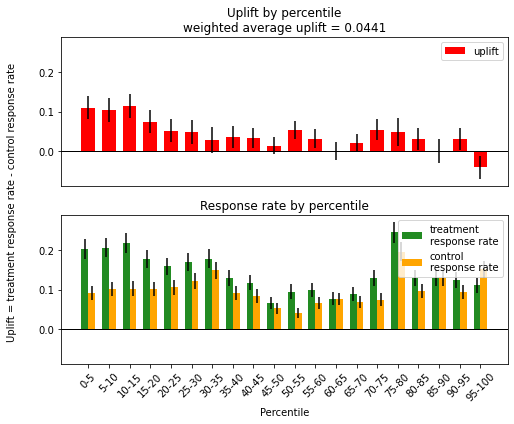

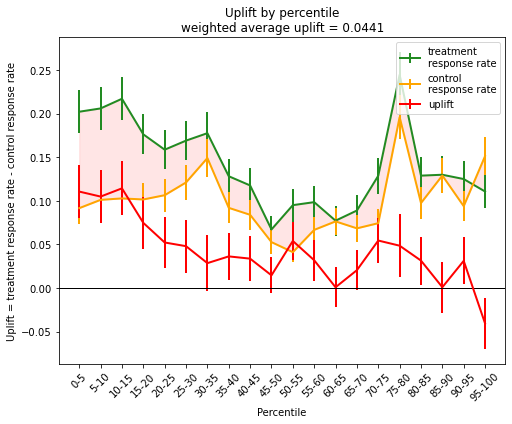

In [35]:
plot_uplift_by_percentile(y_test, models_results['uplift'][3], treat_test,
                          strategy='overall', kind='bar', bins=20)
plot_uplift_by_percentile(y_test, models_results['uplift'][3], treat_test,
                          strategy='overall', kind='line', bins=20)

Можно сказать, что наше модель не смогла идеально найти группу клиентов, который переходили бы на сайт, только после взаимодействия. Больше похоже что первые 65% отранжированных пользователей, дадут аплифт по переходам если сделать на них рассылку. Наблюдается большой скачек в переходе для клиентов отранжированных от 75 до 80% для обоих групп, но тут в целом выделены клиенты, которые бы перешли на этот сайт, возможно это связано с каналом коммуникации, а не наличием взамодействия.

В качестве результата выгрузим модель uplifta

In [36]:
filename = 'finalized_model.sav'
joblib.dump(models_results['model'][3], filename)

['finalized_model.sav']